In [1]:
! pip install simpy

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import simpy
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import matplotlib.pyplot as plt

In [3]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

# 设置输出格式，以显示所有行和列
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 初始化模拟环境和顾客到达过程
def setup(env, num_servers, servicetime, Lambda, waiting_times):
    # 生成服务器资源
    server = simpy.Resource(env, num_servers)

    def service(customer):
        """服务过程使用指数分布的服务时间"""
        yield env.timeout(np.random.exponential(servicetime))

    def customer(name):
        """顾客到达和服务过程"""
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            # 记录每个顾客的等待时间
            waiting_times.append(waiting_time)
    
    # 生成初始顾客
    env.process(customer('Customer 0'))

    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

# 运行模拟函数
def run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # 到达率
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings

from scipy.stats import mannwhitneyu
def perform_mann_whitney_u_test(data1, data2):
    """Perform Mann-Whitney U test between two groups of data."""
    u_statistic, p_value = mannwhitneyu(data1, data2, alternative='less')
    return u_statistic, p_value

In [4]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []
waiting_times_data = {rho: {1: [], 2: [], 4: []} for rho in RHO}

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })
        # 添加等待时间数据
        for wt in sim_data:
            waiting_times_data[rho][num_servers].extend(wt)

# 比较 n=2 与 n=1，n=4 与 n=2 的平均等待时间
for rho in RHO:
    u_statistic, p_value_2_vs_1 = perform_mann_whitney_u_test(waiting_times_data[rho][2], waiting_times_data[rho][1])
    u_statistic, p_value_4_vs_2 = perform_mann_whitney_u_test(waiting_times_data[rho][4], waiting_times_data[rho][2])
    print(f"ρ={rho}: n=2 vs n=1, p-value = {p_value_2_vs_1}; n=4 vs n=2, p-value = {p_value_4_vs_2}")

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


ρ=0.1: n=2 vs n=1, p-value = 0.00028528980768515404; n=4 vs n=2, p-value = 0.9063583627113263
ρ=0.5: n=2 vs n=1, p-value = 2.6924734806932996e-83; n=4 vs n=2, p-value = 4.1593749409303e-68
ρ=0.9: n=2 vs n=1, p-value = 3.468240002993728e-57; n=4 vs n=2, p-value = 4.329161603577195e-282
ρ=0.99: n=2 vs n=1, p-value = 1.9087951531944836e-142; n=4 vs n=2, p-value = 3.105965322282384e-72
    num_servers   rho  avg_waiting_time  \
0             1  0.10          1.050934   
1             2  0.10          0.957486   
2             4  0.10          0.993023   
3             1  0.50          2.005664   
4             2  0.50          1.330829   
5             4  0.50          1.067077   
6             1  0.90          4.273175   
7             2  0.90          3.368820   
8             4  0.90          2.330184   
9             1  0.99          6.935067   
10            2  0.99          4.975558   
11            4  0.99          3.909799   

                                     all_waiting_time  

In [5]:
# 画ρ影响平均等待时间的图

def run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

def prepare_plot_data(simulation_results, server_configs):
    plot_data = {'rho': [], 'avg_waiting_time': [], 'num_servers': []}
    
    for num_servers, all_waiting_times in zip(server_configs, simulation_results):
        for rho, waiting_times in all_waiting_times.items():
            plot_data['rho'].extend([rho] * len(waiting_times))
            plot_data['avg_waiting_time'].extend(waiting_times)
            plot_data['num_servers'].extend([str(num_servers)] * len(waiting_times))
    
    return pd.DataFrame(plot_data)

def plot_data(df):
    sns.lineplot(data=df, x='rho', y='avg_waiting_time', hue='num_servers')
    plt.title('Comparison of Average Waiting Time by System Load')
    plt.xlabel('System Load (ρ)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()


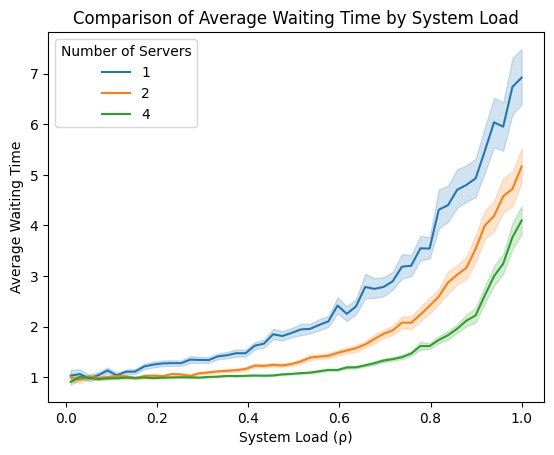

In [6]:
# 定义参数
SIM_TIME = 100
SIMULATIONS = 200
MU = 1
rhos = np.linspace(0.01, 1, 50)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


In [7]:
print(all_sim_data[0]['all_waiting_time'][1])

[0.16003022324206648, 1.3258368957918476, 0.5266978830672855, 0.7080370956100097, 0.4042411800775696, 0.08828086564636806, 1.7850467102668475, 2.363792009892009, 1.4758033029231115, 0.32463927192009123, 0.6158110018849641, 0.062180198250487706, 0.5760627818056463, 3.0806502172540604]


In [8]:
# 绘制直方图或密度图
def plt_distribution(all_sim_data, title, xlabel = 'Waiting Time'):
#     print(len(all_sim_data))
#     sns.histplot(all_sim_data, kde=True, element='step', stat='density', bins=200)
    sns.histplot(all_sim_data, kde=True, stat='density', bins=200)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()
    

# 绘制叠加的直方图或密度图
def plt_distribution_group(sim_data_group, title, labels, xlabel='Average Waiting Time'):
    for group_data, label in zip(sim_data_group, labels):
        sns.histplot(group_data, kde=True, stat='density', bins=200, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def prepare_group_data(sim_data):
    # 将模拟结果中的所有等待时间整理到一个列表中
    all_waiting_times = []
    for data in sim_data:
        all_waiting_times.extend(data)

    return all_waiting_times


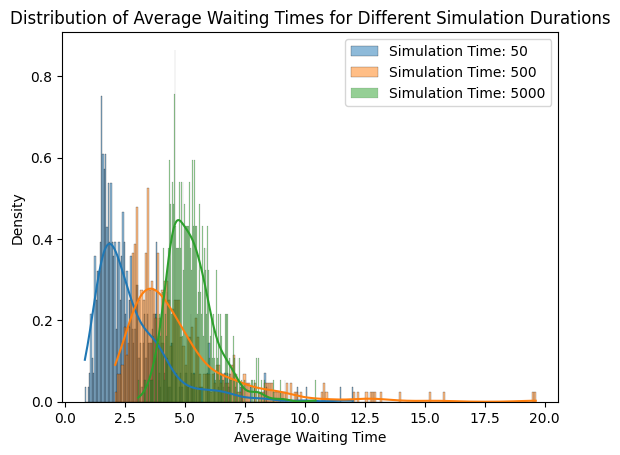

In [9]:
# 定义模拟参数
num_servers = 2  # 服务器数量
rho = 0.9  # 系统负载
MU = 1  # 服务率
SIMULATIONS = 500  # 模拟次数
SIM_TIMES = [50, 500, 5000]  # 不同的模拟时长

# 运行模拟并收集结果
simulation_results = []
for SIM_TIME in SIM_TIMES:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)
    simulation_results.append(avg_waitings)

# 定义标签
labels = [f'Simulation Time: {SIM_TIME}' for SIM_TIME in SIM_TIMES]

# 绘制结果
plt_distribution_group(simulation_results, "Distribution of Average Waiting Times for Different Simulation Durations", labels)


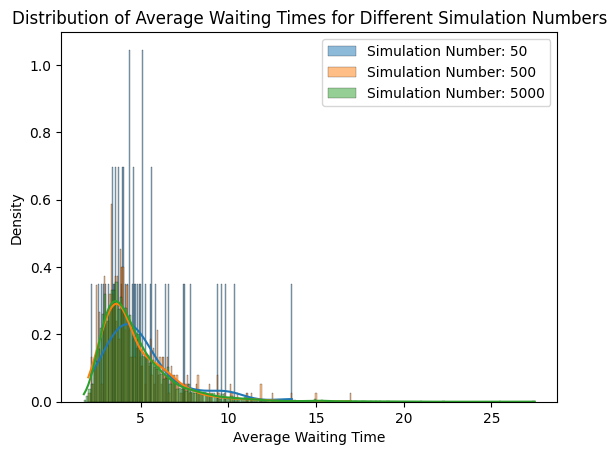

In [10]:
# 定义模拟参数
num_servers = 2  # 服务器数量
rho = 0.9  # 系统负载
MU = 1  # 服务率
SIMULATIONS = [50, 500, 5000]  # 不同的模拟时长
SIM_TIME = 500  # 模拟时长

# 运行模拟并收集结果
simulation_results = []
for SIMULATION in SIMULATIONS:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATION)
    simulation_results.append(avg_waitings)

# 定义标签
labels = [f'Simulation Number: {SIMULATION}' for SIMULATION in SIMULATIONS]

# 绘制结果
plt_distribution_group(simulation_results, "Distribution of Average Waiting Times for Different Simulation Numbers", labels)


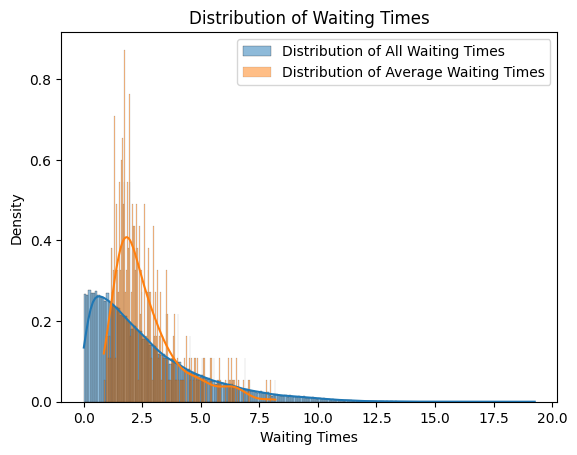

In [11]:
# Simulation parameters
num_servers = 2
rho = 0.9  # System load
MU = 1  # Service rate
SIM_TIME = 50  # Simulation duration
SIMULATIONS = 500  # Number of simulations


sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual

all_waiting_times = []
for data in sim_data:
    all_waiting_times.extend(data)

# plt_distribution(all_waiting_times, 'Distribution of All Waiting Times')
# plt_distribution(avg_waitings, 'Distribution of Average Waiting Times')
group_data = [all_waiting_times, avg_waitings]
labels = ['Distribution of All Waiting Times', 'Distribution of Average Waiting Times']
plt_distribution_group(group_data, "Distribution of Waiting Times", labels, "Waiting Times")

In [12]:
from scipy.stats import mannwhitneyu

def perform_mann_whitney_u_test(data1, data2):
    """Perform Mann-Whitney U test between two groups of data."""
    u_statistic, p_value = mannwhitneyu(data1, data2, alternative='less')
    return u_statistic, p_value


In [13]:
# 模拟参数
SIM_TIME = 50
SIMULATIONS = 30
MU = 1
rho = 0.99

# 运行模拟并收集数据
# avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
# avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
# avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

_, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
_, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
_, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

# print(avg_waitings_1_server)
# print(avg_waitings_2_servers)
# print(avg_waitings_4_servers)

# 进行Mann-Whitney U检验
u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)

print("Mann-Whitney U Test Results:")
print("4 servers vs 2 servers: U-Statistic:", u_stat_4_vs_2, "P-Value:", p_4_vs_2)
print("2 servers vs 1 server: U-Statistic:", u_stat_2_vs_1, "P-Value:", p_2_vs_1)


Mann-Whitney U Test Results:
4 servers vs 2 servers: U-Statistic: 300.0 P-Value: 0.013543159194147968
2 servers vs 1 server: U-Statistic: 317.0 P-Value: 0.025060119631000688


In [14]:
# 模拟参数
SIM_TIME = 50
SIMULATIONS = 120
MU = 1
rho = 0.5

p_4_vs_2_list = []
p_2_vs_1_list = []
for _ in range(10):
    # 运行模拟并收集数据
    # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
    # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
    # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

    _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
    _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
    _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

    # print(avg_waitings_1_server)
    # print(avg_waitings_2_servers)
    # print(avg_waitings_4_servers)

    # 进行Mann-Whitney U检验
    u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
    u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
    
    p_4_vs_2_list.append(p_4_vs_2)
    p_2_vs_1_list.append(p_2_vs_1)
    
p_4_vs_2_mean = np.mean(p_4_vs_2_list)
p_2_vs_1_mean = np.mean(p_2_vs_1_list)

print("Mann-Whitney U Test Results:")
print("4 servers vs 2 servers: U-Statistic:", u_stat_4_vs_2, "P-Value-Mean:", p_4_vs_2_mean)
print("2 servers vs 1 server: U-Statistic:", u_stat_2_vs_1, "P-Value-Mean:", p_2_vs_1_mean)





Mann-Whitney U Test Results:
4 servers vs 2 servers: U-Statistic: 4214.0 P-Value-Mean: 1.0619049876073583e-06
2 servers vs 1 server: U-Statistic: 4321.0 P-Value-Mean: 1.0652579059319716e-06


############  rho = 0.5
SIMULATIONS = 20
0.0371859007594784 0.05216832376446854
SIMULATIONS = 21
0.03819705249710457 0.03475708371182139
############  rho = 0.5544444444444444
SIMULATIONS = 20
0.03989720350238506 0.03395811272846805
############  rho = 0.6088888888888889
SIMULATIONS = 20
0.038577941244458513 0.04613679210486594
############  rho = 0.6633333333333333
SIMULATIONS = 20
0.029249429800581504 0.03840356999369427
############  rho = 0.7177777777777777
SIMULATIONS = 20
0.04330840173579824 0.03029564292624761
############  rho = 0.7722222222222221
SIMULATIONS = 20
0.02250185478137382 0.04717271265316775
############  rho = 0.8266666666666667
SIMULATIONS = 20
0.04380554194097198 0.06945701491007097
SIMULATIONS = 21
0.08391887185511984 0.029810148516712643
SIMULATIONS = 22
0.03782154369500447 0.13830696794891478
SIMULATIONS = 23
0.08260411528255134 0.04641051715756927
SIMULATIONS = 24
0.0310134303065966 0.05199593261905776
SIMULATIONS = 25
0.05820104363726338 0.04013769595462932


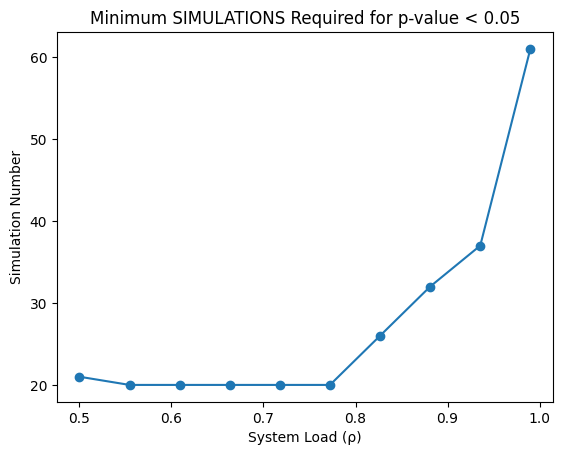

In [15]:
def simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS):
    p_4_vs_2_list = []
    p_2_vs_1_list = []
    for _ in range(20):
        # 运行模拟并收集数据
        # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        # print(avg_waitings_1_server)
        # print(avg_waitings_2_servers)
        # print(avg_waitings_4_servers)

        # 进行Mann-Whitney U检验
        u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
        u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
#         print(p_4_vs_2, p_2_vs_1)

        p_4_vs_2_list.append(p_4_vs_2)
        p_2_vs_1_list.append(p_2_vs_1)
    
    p_4_vs_2_mean = np.mean(p_4_vs_2_list)
    p_2_vs_1_mean = np.mean(p_2_vs_1_list)

    return p_4_vs_2_mean, p_2_vs_1_mean

SIM_TIME = 50
MU = 1
rhos = np.linspace(0.5, 0.99, 10)
simulation_results = []

for rho in rhos:
    SIMULATIONS = 20
    print(f"############  rho = {rho}")
    while True:
        print(f"SIMULATIONS = {SIMULATIONS}")
        p_4_vs_2_mean, p_2_vs_1_mean = simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS)
        print(p_4_vs_2_mean, p_2_vs_1_mean)
        if p_4_vs_2_mean < 0.05 and p_2_vs_1_mean < 0.05:
            break
        SIMULATIONS += 1
    simulation_results.append((rho, SIMULATIONS))

# 绘制图表
rhos, sims = zip(*simulation_results)
plt.plot(rhos, sims, marker='o')
plt.title("Minimum SIMULATIONS Required for p-value < 0.05")
plt.xlabel("System Load (ρ)")
plt.ylabel("Simulation Number")
plt.show()


############  rho = 0.5
SIMULATIONS = 20
0.07834296118056744 0.04403791392323185
SIMULATIONS = 21
0.033644205120333996 0.015556175040112877
############  rho = 0.5544444444444444
SIMULATIONS = 20
0.018455114878406686 0.05772203867756206
SIMULATIONS = 21
0.04251581005693332 0.027699537126071094
############  rho = 0.6088888888888889
SIMULATIONS = 20
0.04318892315160138 0.02019101297757907
############  rho = 0.6633333333333333
SIMULATIONS = 20
0.04886038970947326 0.0296899385903107
############  rho = 0.7177777777777777
SIMULATIONS = 20
0.028021132851881153 0.053826336083596174
SIMULATIONS = 21
0.05512611999310307 0.05294338452916488
SIMULATIONS = 22
0.05174493578448085 0.07033987203272009
SIMULATIONS = 23
0.0182978643284481 0.03634143671365144
############  rho = 0.7722222222222221
SIMULATIONS = 20
0.038144221364789635 0.050727089559394124
SIMULATIONS = 21
0.06009046665447977 0.038609617256247966
SIMULATIONS = 22
0.055649112836275896 0.012792755443671302
SIMULATIONS = 23
0.040701483662

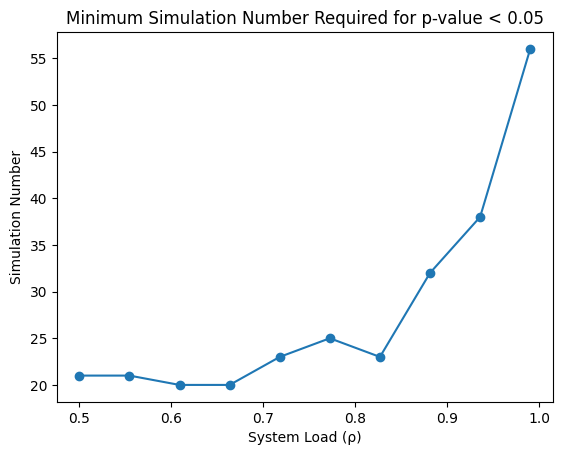

In [16]:
def simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS):
    p_4_vs_2_list = []
    p_2_vs_1_list = []
    for _ in range(20):
        # 运行模拟并收集数据
        # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        # print(avg_waitings_1_server)
        # print(avg_waitings_2_servers)
        # print(avg_waitings_4_servers)

        # 进行Mann-Whitney U检验
        u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
        u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
#         print(p_4_vs_2, p_2_vs_1)

        p_4_vs_2_list.append(p_4_vs_2)
        p_2_vs_1_list.append(p_2_vs_1)
    
    p_4_vs_2_mean = np.mean(p_4_vs_2_list)
    p_2_vs_1_mean = np.mean(p_2_vs_1_list)

    return p_4_vs_2_mean, p_2_vs_1_mean

SIM_TIME = 50
MU = 1
rhos = np.linspace(0.5, 0.99, 10)
simulation_results = []

for rho in rhos:
    SIMULATIONS = 20
    print(f"############  rho = {rho}")
    while True:
        print(f"SIMULATIONS = {SIMULATIONS}")
        p_4_vs_2_mean, p_2_vs_1_mean = simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS)
        print(p_4_vs_2_mean, p_2_vs_1_mean)
        if p_4_vs_2_mean < 0.05 and p_2_vs_1_mean < 0.05:
            break
        SIMULATIONS += 1
    simulation_results.append((rho, SIMULATIONS))

# 绘制图表
rhos, sims = zip(*simulation_results)
plt.plot(rhos, sims, marker='o')
plt.title("Minimum Simulation Number Required for p-value < 0.05")
plt.xlabel("System Load (ρ)")
plt.ylabel("Simulation Number")
plt.show()


############  rho = 0.5
SIMULATIONS = 20
0.059539251606563856 0.08042669376078457
SIMULATIONS = 21
0.02198496337464132 0.02814122047030838
############  rho = 0.5544444444444444
SIMULATIONS = 20
0.021776131406918857 0.014477586493996525
############  rho = 0.6088888888888889
SIMULATIONS = 20
0.036871843689495476 0.028178766407326594
############  rho = 0.6633333333333333
SIMULATIONS = 20
0.023041201960840137 0.03745416968301456
############  rho = 0.7177777777777777
SIMULATIONS = 20
0.01903299131237791 0.04046586317755342
############  rho = 0.7722222222222221
SIMULATIONS = 20
0.057395206075473756 0.02240971734649142
SIMULATIONS = 21
0.06424673718442411 0.020832614305781916
SIMULATIONS = 22
0.05299765568485597 0.04165225513021177
SIMULATIONS = 23
0.04307173852506267 0.030724430149089522
############  rho = 0.8266666666666667
SIMULATIONS = 20
0.042476037023644456 0.06561390272641479
SIMULATIONS = 21
0.051944519536977526 0.022228601643994227
SIMULATIONS = 22
0.012438212484669106 0.103164

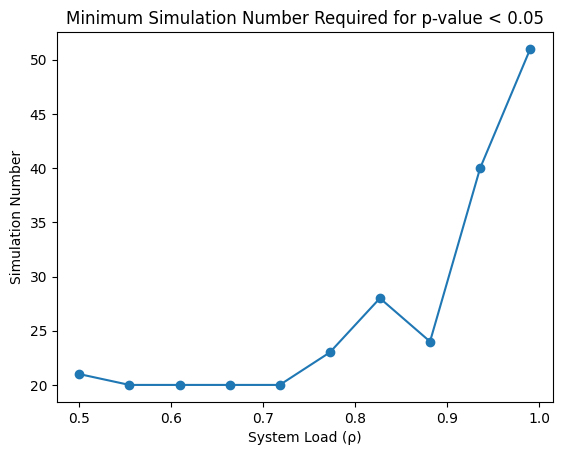

In [17]:
def simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS):
    p_4_vs_2_list = []
    p_2_vs_1_list = []
    for _ in range(20):
        # 运行模拟并收集数据
        # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        # print(avg_waitings_1_server)
        # print(avg_waitings_2_servers)
        # print(avg_waitings_4_servers)

        # 进行Mann-Whitney U检验
        u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
        u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
#         print(p_4_vs_2, p_2_vs_1)

        p_4_vs_2_list.append(p_4_vs_2)
        p_2_vs_1_list.append(p_2_vs_1)
    
    p_4_vs_2_mean = np.mean(p_4_vs_2_list)
    p_2_vs_1_mean = np.mean(p_2_vs_1_list)

    return p_4_vs_2_mean, p_2_vs_1_mean

SIM_TIME = 50
MU = 1
rhos = np.linspace(0.5, 0.99, 10)
simulation_results = []

for rho in rhos:
    SIMULATIONS = 20
    print(f"############  rho = {rho}")
    while True:
        print(f"SIMULATIONS = {SIMULATIONS}")
        p_4_vs_2_mean, p_2_vs_1_mean = simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS)
        print(p_4_vs_2_mean, p_2_vs_1_mean)
        if p_4_vs_2_mean < 0.05 and p_2_vs_1_mean < 0.05:
            break
        SIMULATIONS += 1
    simulation_results.append((rho, SIMULATIONS))

# 绘制图表
rhos, sims = zip(*simulation_results)
plt.plot(rhos, sims, marker='o')
plt.title("Minimum Simulation Number Required for p-value < 0.05")
plt.xlabel("System Load (ρ)")
plt.ylabel("Simulation Number")
plt.show()


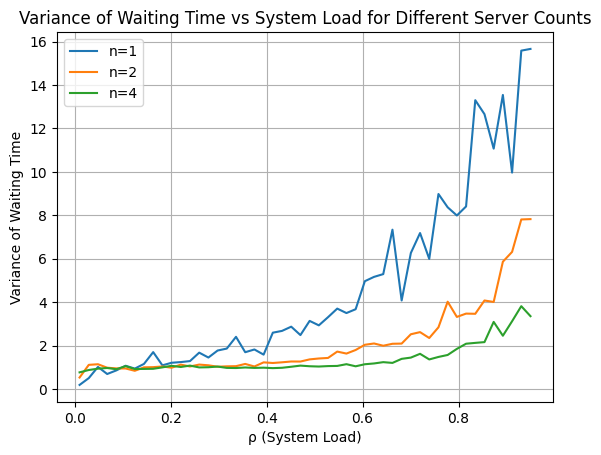

In [51]:
def run_simulation_with_variance(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # Arrival rate

    variances = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        variance = np.var(waiting_times)
        variances.append(variance)
    return np.mean(variances)

# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 50  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHOS = np.linspace(0.01, 0.95, 50)  # System load

# Dictionary to store variances for different server numbers and rhos
variances = {num_servers: [] for num_servers in SERVERS}

# Run simulations and collect variances
for num_servers in SERVERS:
    for rho in RHOS:
        variance = run_simulation_with_variance(num_servers, rho, MU, SIM_TIME, SIMULATIONS)
        variances[num_servers].append(variance)

# Plotting the variances
# plt.figure(figsize=(10, 6))
for num_servers, variance_data in variances.items():
    plt.plot(RHOS, variance_data, label=f'n={num_servers}')
plt.xlabel('ρ (System Load)')
plt.ylabel('Variance of Waiting Time')
plt.title('Variance of Waiting Time vs System Load for Different Server Counts')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# 初始化模拟环境和顾客到达过程
def setup_MDn(env, num_servers, servicetime, Lambda, waiting_times):
    # 生成服务器资源
    server = simpy.Resource(env, num_servers)

    def service(customer):
        """服务过程使用指数分布的服务时间"""
        yield env.timeout(servicetime)

    def customer(name):
        """顾客到达和服务过程"""
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            # 记录每个顾客的等待时间
            waiting_times.append(waiting_time)
    
    # 生成初始顾客
    env.process(customer('Customer 0'))

    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

# 运行模拟函数
def run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # 到达率
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_MDn(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [19]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          1.052381   
1             2  0.10          1.004489   
2             4  0.10          1.000305   
3             1  0.50          1.483164   
4             2  0.50          1.165891   
5             4  0.50          1.052415   
6             1  0.90          3.557962   
7             2  0.90          2.683508   
8             4  0.90          1.792196   
9             1  0.99          5.669557   
10            2  0.99          3.747149   
11            4  0.99          2.885214   

                                     all_waiting_time  \
0   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
1   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
2   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
3   [[1.0, 1.0, 1.0, 1.8455121176120155, 1.6912118...   
4   [[1.0, 1.0000000000000002, 1.0, 1.793355335998...   
5   [[1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0,...   
6   [[1.0, 1.0, 1.3829296580689547, 1.983

In [20]:
# 画ρ影响平均等待时间的图

def run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

def prepare_plot_data(simulation_results, server_configs):
    plot_data = {'rho': [], 'avg_waiting_time': [], 'num_servers': []}
    
    for num_servers, all_waiting_times in zip(server_configs, simulation_results):
        for rho, waiting_times in all_waiting_times.items():
            plot_data['rho'].extend([rho] * len(waiting_times))
            plot_data['avg_waiting_time'].extend(waiting_times)
            plot_data['num_servers'].extend([str(num_servers)] * len(waiting_times))
    
    return pd.DataFrame(plot_data)


def plot_data(df, title = "Comparison of Average Waiting Time by System Load"):
    sns.lineplot(data=df, x='rho', y='avg_waiting_time', hue='num_servers')
    plt.title(title)
    plt.xlabel('System Load (ρ)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()


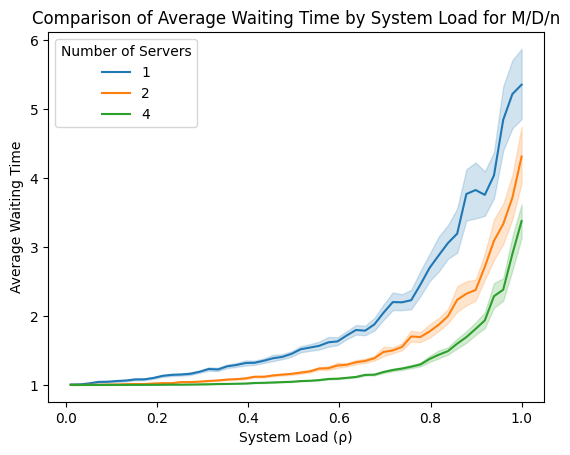

In [21]:
# 定义参数
SIM_TIME = 100
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 50)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df, "Comparison of Average Waiting Time by System Load for M/D/n")


# Compare M/M/1 queue with shortest job first scheduling

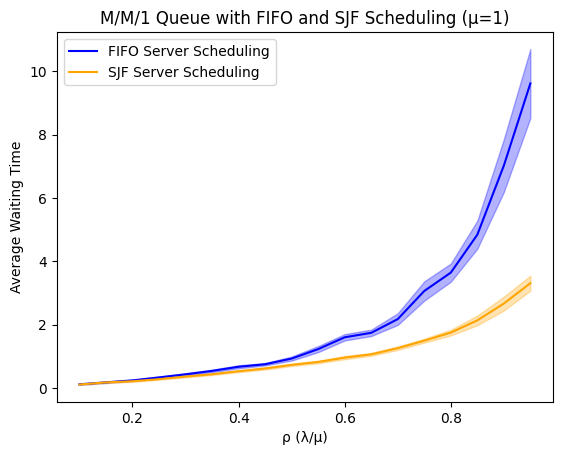

In [22]:
# 不同Rho（固定MU）的情况下，M/M/1和shortest job first scheduling的对比
# Function for confidence interval calculation
def conf_int(mean, std_dev, n, p=0.95):
    z_value = st.norm.ppf((p + 1) / 2)
    margin = (z_value * std_dev) / math.sqrt(n)
    return mean - margin, mean + margin

# Adjusted job_generator to accept lambda_val
def job_generator(env, server, waiting_times, lambda_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.expovariate(MU)
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted serve to create job with service_time
def serve(env, job, server, waiting_times):
    if isinstance(server, simpy.PriorityResource): 
        request = server.request(priority=job.service_time)  # For SJF, request with job's service time as priority.
    else:
        request = server.request() # For FIFO, regular request without priority.
    
    with request as req:
        yield req # Wait for the server to be available.
        wait = env.now - job.arrive_time # Calculate waiting time.
        waiting_times.append(wait)
        yield env.timeout(job.service_time)

# Class Job with added service_time parameter
class Job:
    def __init__(self, name, arrive_time, service_time):
        self.name = name
        self.arrive_time = arrive_time
        self.service_time = service_time

# Adjusted run_simulation to accept lambda_val and pass it to job_generator
def run_simulation_sjfs(server_type, lambda_val):
    env = simpy.Environment()
    waiting_times = []
    if server_type == 'SJF':
        server = simpy.PriorityResource(env, capacity=1)
    else:
        server = simpy.Resource(env, capacity=1)
    
    env.process(job_generator(env, server, waiting_times, lambda_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)  # Return the average waiting time for this simulation


# Parameters
MU = 1  # Fixed service rate
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging

# Prepare a range of rho values
rhos = np.arange(0.1, 1.0, 0.05)
results = []

for rho in rhos:
    lambda_val = rho * MU
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation_sjfs(queue_type, lambda_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting
colors = ['blue', 'orange']  # Define colors for the different lines, adjust as needed for your categories

for i, queue_type in enumerate(['FIFO', 'SJF']):
    subset = results_df[results_df['QueueType'] == queue_type]
    # Plot the mean waiting time line
    plt.plot(subset['Rho'], subset['MeanWait'], label=f'{queue_type} Server Scheduling', color=colors[i])
    # Fill between the upper and lower confidence interval bounds
    plt.fill_between(subset['Rho'],
                     subset['ConfIntervalLower'],
                     subset['ConfIntervalUpper'],
                     color=colors[i], alpha=0.3)  # Adjust alpha for transparency

plt.xlabel('ρ (λ/μ)')
plt.ylabel('Average Waiting Time')
plt.title('M/M/1 Queue with FIFO and SJF Scheduling (μ=1)')
plt.legend()
plt.show()

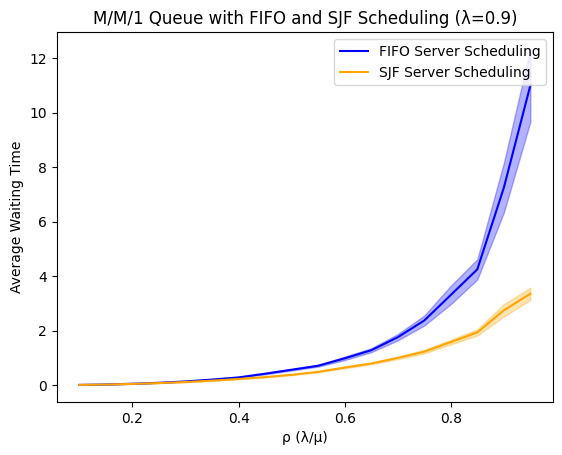

In [23]:
# 不同Rho（固定Lambda）的情况下，M/M/1和shortest job first scheduling的对比
# Adjusted job_generator to accept mu_val
def job_generator(env, server, waiting_times, lambda_val, mu_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.expovariate(mu_val)
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted run_simulation to accept mu_val and pass it to job_generator
def run_simulation_sjfs(server_type, lambda_val, mu_val):
    env = simpy.Environment()
    waiting_times = []
    if server_type == 'SJF':
        server = simpy.PriorityResource(env, capacity=1)
    else:
        server = simpy.Resource(env, capacity=1)
    
    env.process(job_generator(env, server, waiting_times, lambda_val, mu_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)

# Fixed parameters
LAMBDA = 0.9  # Fixed arrival rate
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging

# Prepare a range of rho values and calculate corresponding mu values
rhos = np.arange(0.1, 1.0, 0.05)
results = []

for rho in rhos:
    mu_val = LAMBDA / rho  # Calculate mu for each rho
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation_sjfs(queue_type, LAMBDA, mu_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting
colors = ['blue', 'orange']  # Define colors for the different lines, adjust as needed for your categories

for i, queue_type in enumerate(['FIFO', 'SJF']):
    subset = results_df[results_df['QueueType'] == queue_type]
    # Plot the mean waiting time line
    plt.plot(subset['Rho'], subset['MeanWait'], label=f'{queue_type} Server Scheduling', color=colors[i])
    # Fill between the upper and lower confidence interval bounds
    plt.fill_between(subset['Rho'],
                     subset['ConfIntervalLower'],
                     subset['ConfIntervalUpper'],
                     color=colors[i], alpha=0.3)  # Adjust alpha for transparency

plt.xlabel('ρ (λ/μ)')
plt.ylabel('Average Waiting Time')
plt.title('M/M/1 Queue with FIFO and SJF Scheduling (λ=0.9)')
plt.legend()
plt.show()

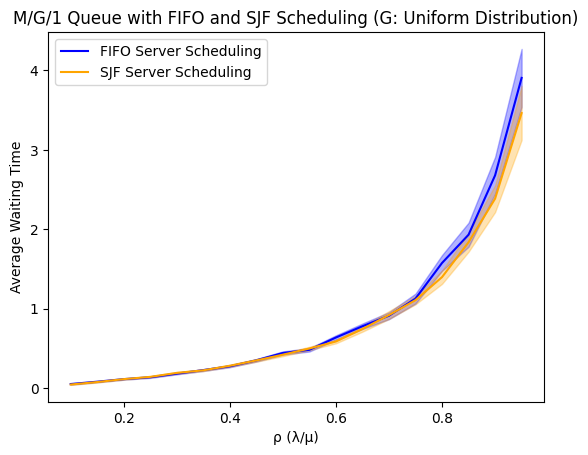

In [24]:
# 把job lengths改为稳定的分布会缩小M/M/1和shortest job first scheduling的差异
# Adjusted job_generator for consistent job lengths and lambda_val
def job_generator(env, server, waiting_times, lambda_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.uniform(0.9, 1.0)  # Consistent job lengths
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted run_simulation
def run_simulation_sjfs(server_type, lambda_val):
    env = simpy.Environment()
    waiting_times = []
    server = simpy.PriorityResource(env, capacity=1) if server_type == 'SJF' else simpy.Resource(env, capacity=1)
    env.process(job_generator(env, server, waiting_times, lambda_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)

# Parameters
MU = 1  # Fixed service rate (MU)
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging
rhos = np.arange(0.1, 1.0, 0.05)  # Range of rho values

# Run the simulation
results = []
for rho in rhos:
    lambda_val = rho * MU  # Calculate lambda for each rho
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation_sjfs(queue_type, lambda_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame and plot
results_df = pd.DataFrame(results)

# Plotting
colors = ['blue', 'orange']  # Define colors for the different lines, adjust as needed for your categories

for i, queue_type in enumerate(['FIFO', 'SJF']):
    subset = results_df[results_df['QueueType'] == queue_type]
    # Plot the mean waiting time line
    plt.plot(subset['Rho'], subset['MeanWait'], label=f'{queue_type} Server Scheduling', color=colors[i])
    # Fill between the upper and lower confidence interval bounds
    plt.fill_between(subset['Rho'],
                     subset['ConfIntervalLower'],
                     subset['ConfIntervalUpper'],
                     color=colors[i], alpha=0.3)  # Adjust alpha for transparency

plt.xlabel('ρ (λ/μ)')
plt.ylabel('Average Waiting Time')
plt.title('M/G/1 Queue with FIFO and SJF Scheduling (G: Uniform Distribution)')
plt.legend()
plt.show()

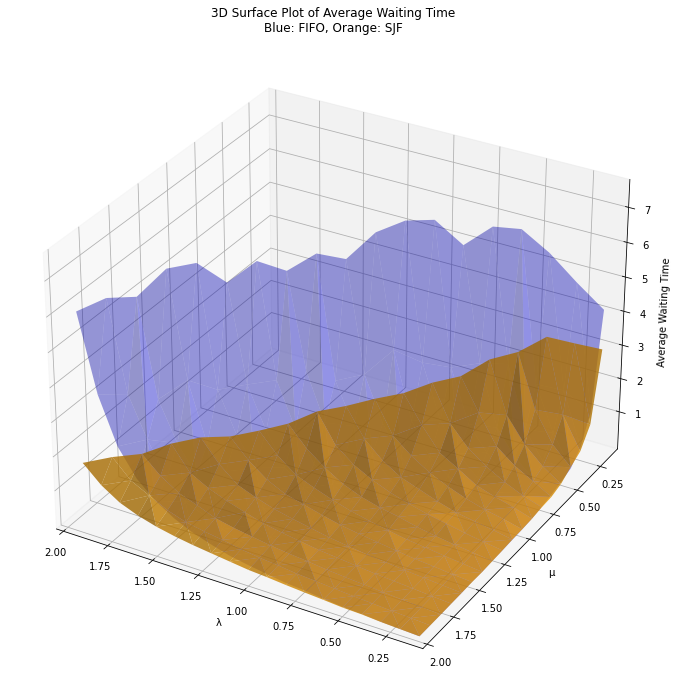

In [3]:
import simpy
import random
import numpy as np
import pandas as pd
import math
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Function for confidence interval calculation
def conf_int(mean, std_dev, n, p=0.95):
    z_value = st.norm.ppf((p + 1) / 2)
    margin = (z_value * std_dev) / math.sqrt(n)
    return mean - margin, mean + margin

# Adjusted job_generator to accept lambda_val and mu_val
def job_generator(env, server, waiting_times, lambda_val, mu_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.expovariate(mu_val)
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted serve to create job with service_time
def serve(env, job, server, waiting_times):
    if isinstance(server, simpy.PriorityResource): 
        request = server.request(priority=job.service_time)  # For SJF, request with job's service time as priority.
    else:
        request = server.request() # For FIFO, regular request without priority.
    
    with request as req:
        yield req # Wait for the server to be available.
        wait = env.now - job.arrive_time # Calculate waiting time.
        waiting_times.append(wait)
        yield env.timeout(job.service_time)

# Class Job with added service_time parameter
class Job:
    def __init__(self, name, arrive_time, service_time):
        self.name = name
        self.arrive_time = arrive_time
        self.service_time = service_time

# Adjusted run_simulation to accept lambda_val and mu_val
def run_simulation(server_type, lambda_val, mu_val):
    env = simpy.Environment()
    waiting_times = []
    server = simpy.PriorityResource(env, capacity=1) if server_type == 'SJF' else simpy.Resource(env, capacity=1)
    env.process(job_generator(env, server, waiting_times, lambda_val, mu_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)  # Return the average waiting time for this simulation

# Parameters
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging
MU_values = np.arange(0.1, 2.1, 0.1)  # Example range for MU
Lambda_values = np.arange(0.1, 2.1, 0.1)  # Example range for Lambda

# Run the simulation
results = []

for MU in MU_values:
    for Lambda in Lambda_values:
        # Ensure that rho (Lambda / MU) is less than 1
        if Lambda < MU:  # This ensures that rho < 1
            for queue_type in ['FIFO', 'SJF']:
                avg_wait_times = []
                for _ in range(SIMULATIONS):
                    avg_wait_time = run_simulation(queue_type, Lambda, MU)
                    avg_wait_times.append(avg_wait_time)
                mean_wait = np.mean(avg_wait_times)
                std_dev_wait = np.std(avg_wait_times, ddof=1)
                conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
                results.append({
                    'MU': MU, 'Lambda': Lambda, 'QueueType': queue_type, 
                    'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
                    'ConfIntervalUpper': conf_upper
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create the 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

for queue_type in ['FIFO', 'SJF']:
    subset = results_df[results_df['QueueType'] == queue_type]
    if queue_type == 'SJF':
        # Non-transparent surface for SJF
        ax.plot_trisurf(subset['Lambda'], subset['MU'], subset['MeanWait'], color='orange', alpha=0.8, label='SJF')
    else:
        # Transparent surface for FIFO
        ax.plot_trisurf(subset['Lambda'], subset['MU'], subset['MeanWait'], color='blue', alpha=0.4, label='FIFO')

    
ax.set_xlim([2.0, 0.1])
ax.set_ylim([2.0, 0.1])
ax.set_xlabel('λ')
ax.set_ylabel('μ')
ax.set_zlabel('Average Waiting Time')
ax.set_title('3D Surface Plot of Average Waiting Time\nBlue: FIFO, Orange: SJF')

plt.show()



# Long tail distribution

In [25]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

def setup_tail(env, num_servers, Lambda, waiting_times):
    server = simpy.Resource(env, num_servers)

    def service(customer):
        # 随机选择服务时间分布
        if np.random.rand() < 0.75:  # 75%的情况，使用平均服务时间为1.0的指数分布
            yield env.timeout(np.random.exponential(1.0))
        else:  # 剩余25%的情况，使用平均服务时间为5.0的指数分布
            yield env.timeout(np.random.exponential(5.0))

    def customer(name):
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            waiting_times.append(waiting_time)
    
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

def run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    Lambda = rho * (MU * num_servers)
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_tail(env, num_servers, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [26]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          2.339611   
1             2  0.10          1.872381   
2             4  0.10          1.858250   
3             1  0.50         10.552922   
4             2  0.50          8.278103   
5             4  0.50          6.455527   
6             1  0.90         22.707247   
7             2  0.90         22.891495   
8             4  0.90         21.420852   
9             1  0.99         25.403496   
10            2  0.99         24.811850   
11            4  0.99         25.035854   

                                     all_waiting_time  \
0   [[0.2850197264473282, 0.43405575354099746, 1.1...   
1   [[0.7518411027293528, 20.645492310272644, 0.62...   
2   [[1.1785622553435418, 0.7112474201101051, 3.35...   
3   [[0.20013884020539863, 1.1702237030851927, 0.7...   
4   [[0.0016964627687205414, 0.6947890714375795, 0...   
5   [[0.29518291952905085, 0.16790569901681152, 1....   
6   [[0.30814942501793163, 1.121363638249

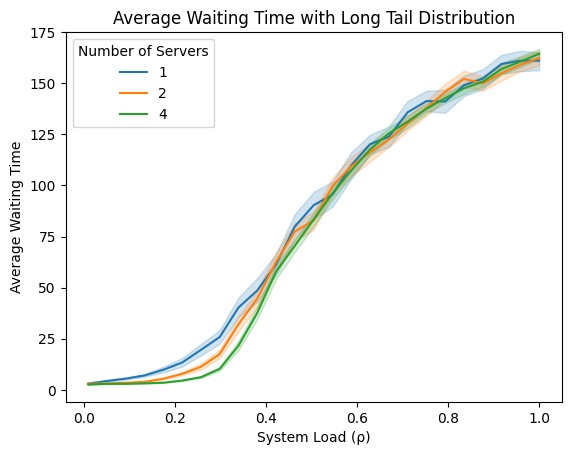

In [46]:
def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df, "Average Waiting Time with Long Tail Distribution")


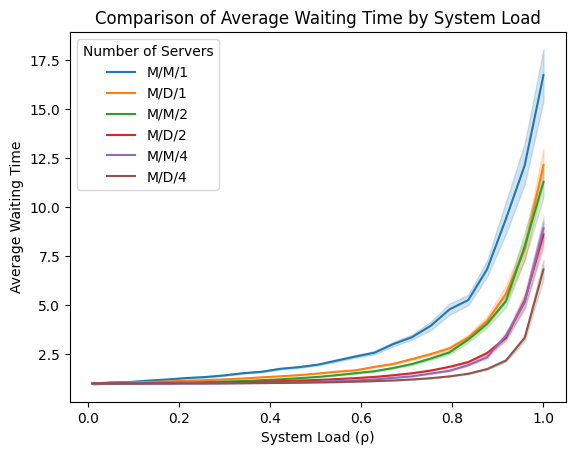

In [28]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 200
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/1", "M/D/1","M/M/2", "M/D/2","M/M/4", "M/D/4"]  # 图片标签

simulation_results = []

num_servers = 1
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
num_servers = 2
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
num_servers = 4
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))


# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


C:\Users\liaojw\AppData\Local\Temp\ipykernel_12736\88074407.py:3: UserWarning: 
The dashes list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df2, x='rho', y='avg_waiting_time', hue='num_servers', style='num_servers', dashes=[(2, 2)], palette=['b', 'g', 'r'])


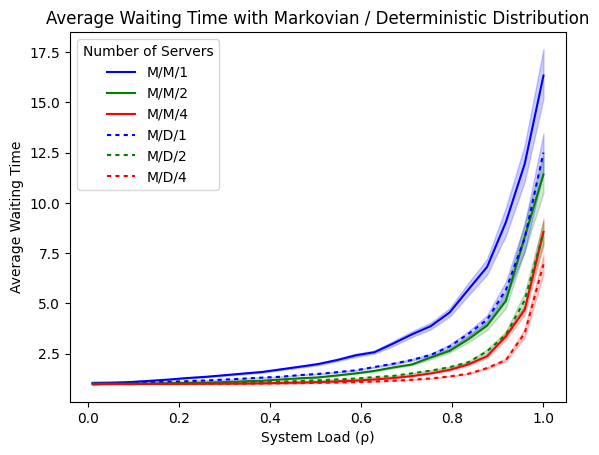

In [47]:
def plot_data_for_2df(df1, df2, title = "Average Waiting Time with Markovian / Deterministic Distribution"):
    sns.lineplot(data=df1, x='rho', y='avg_waiting_time', hue='num_servers', style='num_servers', dashes=False, palette=['b', 'g', 'r'])
    sns.lineplot(data=df2, x='rho', y='avg_waiting_time', hue='num_servers', style='num_servers', dashes=[(2, 2)], palette=['b', 'g', 'r'])
    
    plt.title(title)
    plt.xlabel('System Load (ρ)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()

def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 200
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs1 = ["M/M/1", "M/M/2", "M/M/4"]  # 图片标签
server_configs2 = ["M/D/1", "M/D/2", "M/D/4"]

simulation_results1 = []
simulation_results2 = []

num_servers = 1
simulation_results1.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results2.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
num_servers = 2
simulation_results1.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results2.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
num_servers = 4
simulation_results1.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results2.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))


# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df1 = prepare_plot_data(simulation_results1, server_configs1)
plot_df2 = prepare_plot_data(simulation_results2, server_configs2)

# 绘制数据
plot_data_for_2df(plot_df1, plot_df2)


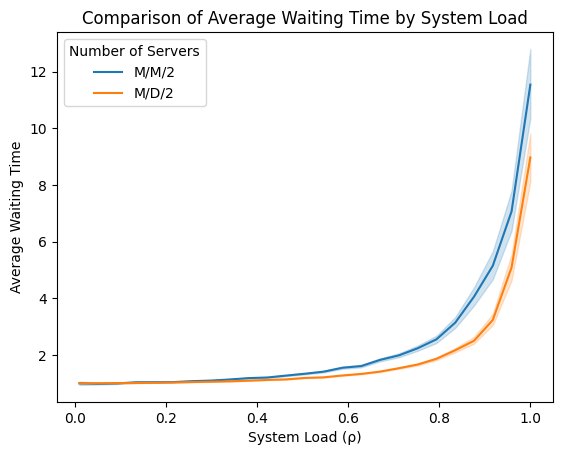

In [32]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/2", "M/D/2", "Long Tail with c = 2"]  # 图片标签

simulation_results = []

num_servers = 2
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


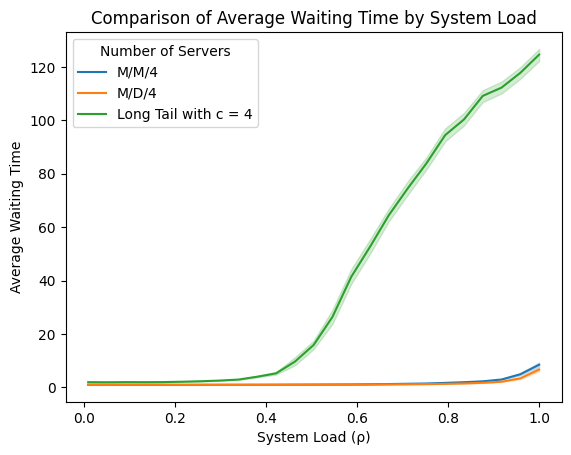

In [33]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/4", "M/D/4", "Long Tail with c = 4"]  # 图片标签

simulation_results = []

num_servers = 4
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


# 改变long tail的分布为50%-50%

In [34]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

def setup_tail(env, num_servers, Lambda, waiting_times):
    server = simpy.Resource(env, num_servers)

    def service(customer):
        # 随机选择服务时间分布
        if np.random.rand() < 0.50:  # 50%的情况，使用平均服务时间为1.0的指数分布
            yield env.timeout(np.random.exponential(1.0))
        else:  # 剩余50%的情况，使用平均服务时间为5.0的指数分布
            yield env.timeout(np.random.exponential(5.0))

    def customer(name):
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            waiting_times.append(waiting_time)
    
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

def run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    Lambda = rho * (MU * num_servers)
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_tail(env, num_servers, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [35]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          3.810965   
1             2  0.10          3.179169   
2             4  0.10          2.971391   
3             1  0.50         18.912350   
4             2  0.50         18.770440   
5             4  0.50         17.932642   
6             1  0.90         32.345273   
7             2  0.90         31.522903   
8             4  0.90         31.783219   
9             1  0.99         33.749726   
10            2  0.99         33.409838   
11            4  0.99         32.200885   

                                     all_waiting_time  \
0   [[0.7148094145420423, 1.281285663354911, 14.70...   
1   [[0.542665449084601, 0.42203946544947346, 2.16...   
2   [[0.11117021510416558, 0.34482550977641413, 5....   
3   [[2.0518124784716343, 0.28126227609537047, 0.1...   
4   [[0.2569196146286272, 0.333157713603335, 2.794...   
5   [[0.172710562886776, 1.2679960647171442, 0.229...   
6   [[5.842555272394487, 16.3721284701190

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


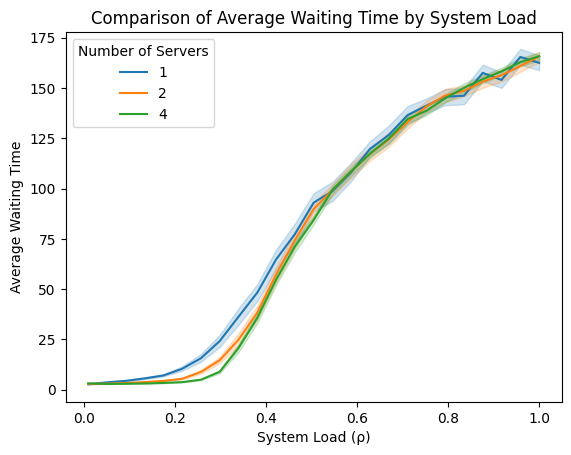

In [36]:
def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


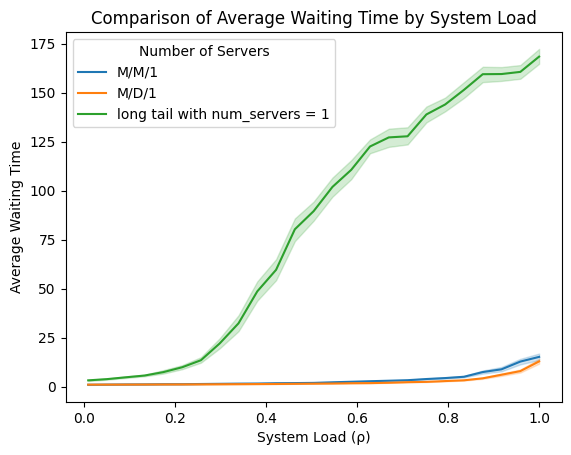

In [37]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/1", "M/D/1", "long tail with num_servers = 1"]  # 图片标签

simulation_results = []

num_servers = 1
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


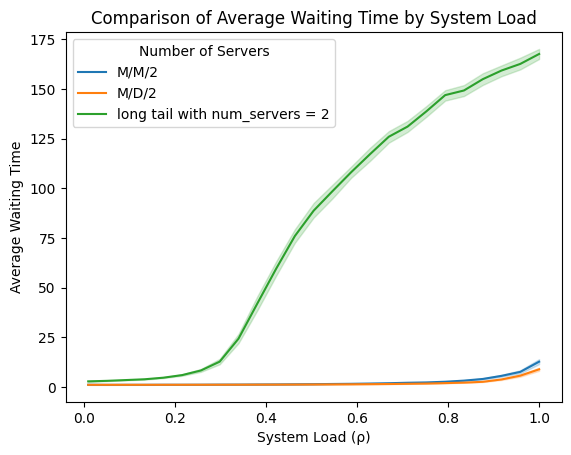

In [38]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/2", "M/D/2", "long tail with num_servers = 2"]  # 图片标签

simulation_results = []

num_servers = 2
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


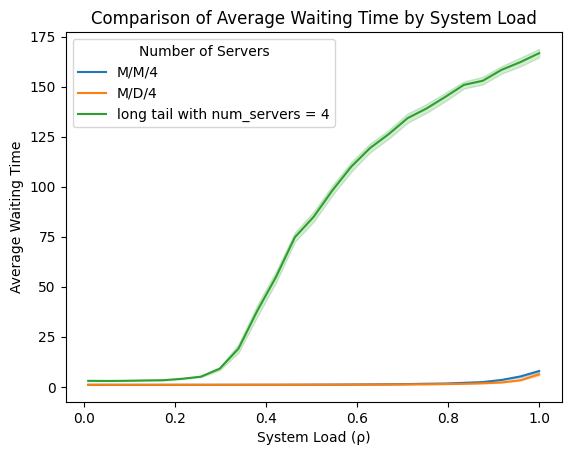

In [39]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/4", "M/D/4", "long tail with num_servers = 4"]  # 图片标签

simulation_results = []

num_servers = 4
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


# 改变Long tail的service time（分别为1和9）

In [40]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

def setup_tail(env, num_servers, Lambda, waiting_times):
    server = simpy.Resource(env, num_servers)

    def service(customer):
        # 随机选择服务时间分布
        if np.random.rand() < 0.75:  # 75%的情况，使用平均服务时间为1.0的指数分布
            yield env.timeout(np.random.exponential(1.0))
        else:  # 剩余25%的情况，使用平均服务时间为5.0的指数分布
            yield env.timeout(np.random.exponential(9.0))

    def customer(name):
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            waiting_times.append(waiting_time)
    
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

def run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    Lambda = rho * (MU * num_servers)
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_tail(env, num_servers, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [41]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          4.534795   
1             2  0.10          2.868874   
2             4  0.10          2.816756   
3             1  0.50         21.436821   
4             2  0.50         17.605626   
5             4  0.50         16.033453   
6             1  0.90         29.951618   
7             2  0.90         29.971386   
8             4  0.90         29.676757   
9             1  0.99         30.941638   
10            2  0.99         31.517991   
11            4  0.99         30.720951   

                                     all_waiting_time  \
0   [[0.7163306414181545, 2.5600813879044813, 10.8...   
1   [[0.24656627657995855, 0.4510825889889638, 0.5...   
2   [[3.158811575707057, 0.24378265155175072, 0.13...   
3   [[0.5210221114065825, 13.258631794148364, 13.6...   
4   [[0.054328432080287925, 4.799806472019145, 2.8...   
5   [[0.4367833100561132, 0.8590273975603844, 0.03...   
6   [[2.8211383100159417, 0.3552169440119

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


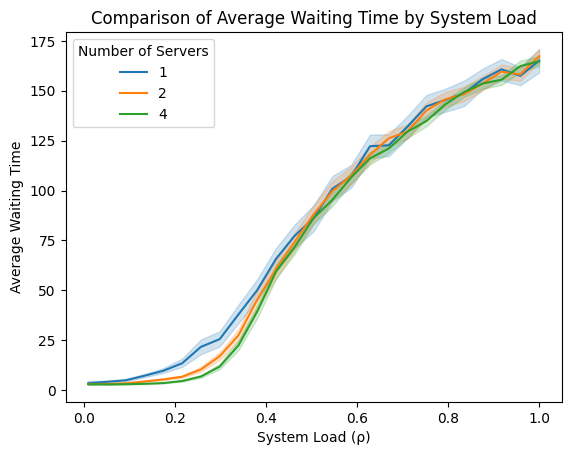

In [42]:
def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


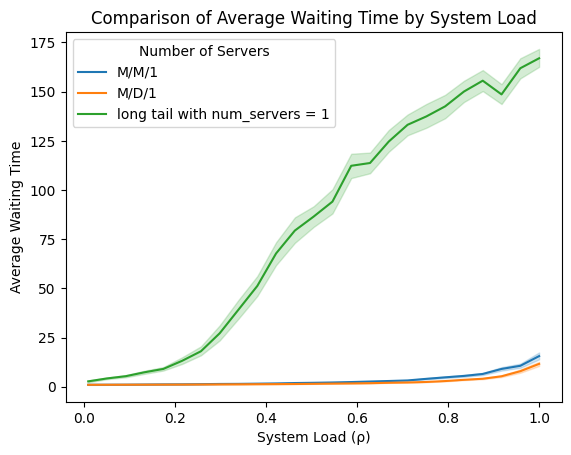

In [43]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/1", "M/D/1", "long tail with num_servers = 1"]  # 图片标签

simulation_results = []

num_servers = 1
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


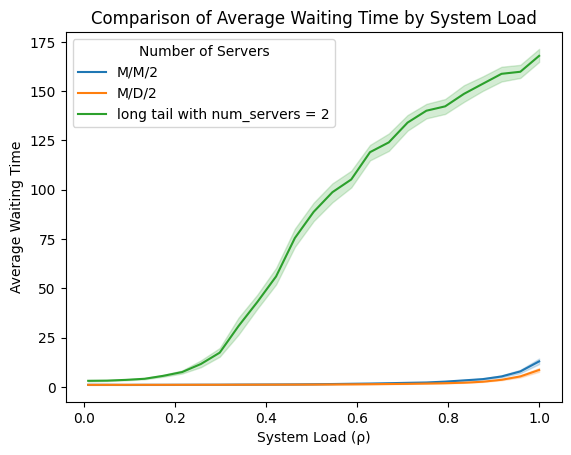

In [44]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/2", "M/D/2", "long tail with num_servers = 2"]  # 图片标签

simulation_results = []

num_servers = 2
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


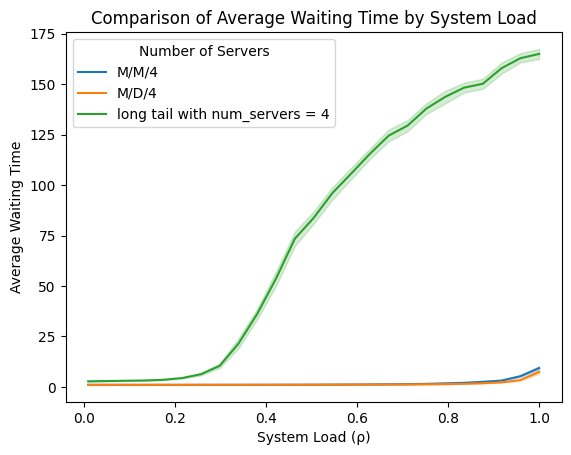

In [45]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/4", "M/D/4", "long tail with num_servers = 4"]  # 图片标签

simulation_results = []

num_servers = 4
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


### 不用的代码

In [ ]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

# 设置输出格式，以显示所有行和列
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 定义队列类
class Queue:
    def __init__(self, env, num_servers, servicetime):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.servicetime = servicetime

    def service(self, customer):
        """服务过程使用指数分布的服务时间"""
        yield self.env.timeout(np.random.exponential(self.servicetime))

# 定义顾客到达过程
def customer(env, name, qu):
    arrival_time = env.now
    with qu.server.request() as request:
        yield request
        yield env.process(qu.service(name))
        waiting_time = env.now - arrival_time
        # 记录每个顾客的等待时间
        qu.env.waiting_times.append(waiting_time)

# 初始化模拟环境和顾客到达过程
def setup(env, num_servers, servicetime, Lambda):
    queue = Queue(env, num_servers, servicetime)
    queue.env.waiting_times = []
    # 生成初始顾客
    env.process(customer(env, 'Customer 0', queue))
    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(env, f'Customer {env.now}', queue))

# 运行模拟函数
def run_simulation(num_servers, Lambda, servicetime, SIM_TIME, SIMULATIONS):
    data_sims = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        env.process(setup(env, num_servers, servicetime, Lambda))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(env.waiting_times)
        data_sims.append(avg_waiting)
    return data_sims

# 模拟参数
MU = 1  # the capacity of each of n equal servers
SIM_TIME = 100
SIMULATIONS = 100
SERVERS = [1, 2, 4]  # 服务器数量n
RHO = [0.5, 0.9, 0.99]  # the system load, RHO = Lambda / (MU * n)

# 存储所有模拟的结果
all_sim_data = []

# 对每个服务器数量n和系统负载ρ运行模拟
for num_servers in SERVERS:
    for rho in RHO:
        Lambda = rho * (MU * num_servers)  # the arrival rate into the system as a whole
        sim_data = run_simulation(num_servers, Lambda, 1/MU, SIM_TIME, SIMULATIONS)
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(sim_data),
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(sim_data), scale=stats.sem(sim_data))
        })

# 将结果转换为DataFrame并保存为CSV文件
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)
